## <strong> <a style="color:black">LSTM Model Accuracy for all Stocks </a> </strong> 

---

|  |  |
|:---|:---|
|**Reading Time** |  20 minutes |
|**Packages used** | Defined with relevant DocStrings within repository   |
|**Models** | Read already tuned models saved in repository ./model/output/LSTM/|
|**Outcome** | Comparison of the model accuracy for 2 scenarios | 
| | 1) Daily prediction for next day stock price and comparing it with actual trend|
| | 2) Multi-step forecasting in future at time t=0 by using predicted values as inputs, and comparing it with actual trend|

## Aim 

Final aim is to build a portoflio of stocks. Weights for each stock in the portoflio is identified based on the mean-variance model i.e. a simulation approach in which we minmise the variance of the portfolio for the given return. Return paramater used for each stock in the mean-variance model is obtained as per the predcition of the trained LSTM model while variance and correlation paramater is based on their historical data.

In this notebook, I have demonstrated the performance of each individual trained LSTM model for the set of below stocks and finally a portfolio is constructed using the mean-variance model.


| **Stocks** |
| :---|
| State Bank of India |
| Reliance |
| Airtel |
| ONGC |
| Tech Mahindra |
| HUL |
| TCS |
| Asian Paints|
| Eicher Motors |
| Axis Bank |

---

In [1]:
import os
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir("..")

In [3]:
from model.utils.forecasting_methods import read_trained_model_and_scaler, get_data, pre_processing
from model.utils.forecasting_methods import forecast_one_day, multistep_forecasting
from model.utils.plots import plotting_trend

In [4]:
start_date = dt.date(2022, 4, 1) # test set start data
end_date = dt.datetime.today()
path = os.getcwd() + r"/model/output/LSTM/" # main model output saved path
rol_freq = 10 # number of past days used in prediction

### Feature Selection : A LSTM model was trained based on the below features to predict the next day price:-

| **Price History**| **Technical Indicators**|
| :---| :---|
| Last 10 day price history of Stock|  Simple Moving Average of Last 20 days|
|| Simple Moving Average of Last 50 days| 
|| Relative Strength Index (RSI)|
|| Moving Average Convergence Divergence|
|| Upper and lower Bollinger Band|

---

### Performance of the model

I have plotted 2 types of plots to demonstrate the performance of the model: - 


1. ) Predict next day stock price based on the updated new features by incorporating the efffect of new day data due to each passing day in the features.

2. )  Predict price based on multi-step forecasting technique where I have used the predicted values from the model as an input to predict the further next day price in future, thus, all future values of stock price are predicted at the time t=0.

---

### State Bank of India

In [5]:
stock = "SBI"
ticker = "SBIN.NS"
df_hist = get_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [6]:
%%capture
model, scaler = read_trained_model_and_scaler(stock, path)

In [7]:
df_features, technical_indicator_features = pre_processing(df_hist, rol_freq)
df_forecast_one_day = forecast_one_day(df_features, rol_freq, model, scaler, technical_indicator_features)
num_of_days_to_predict_in_future = 60
df_multi_step_forecasting, prediction_start_date = multistep_forecasting(df_features, rol_freq, model, scaler, num_of_days_to_predict_in_future)

2023-06-22 11:45:30.635583: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


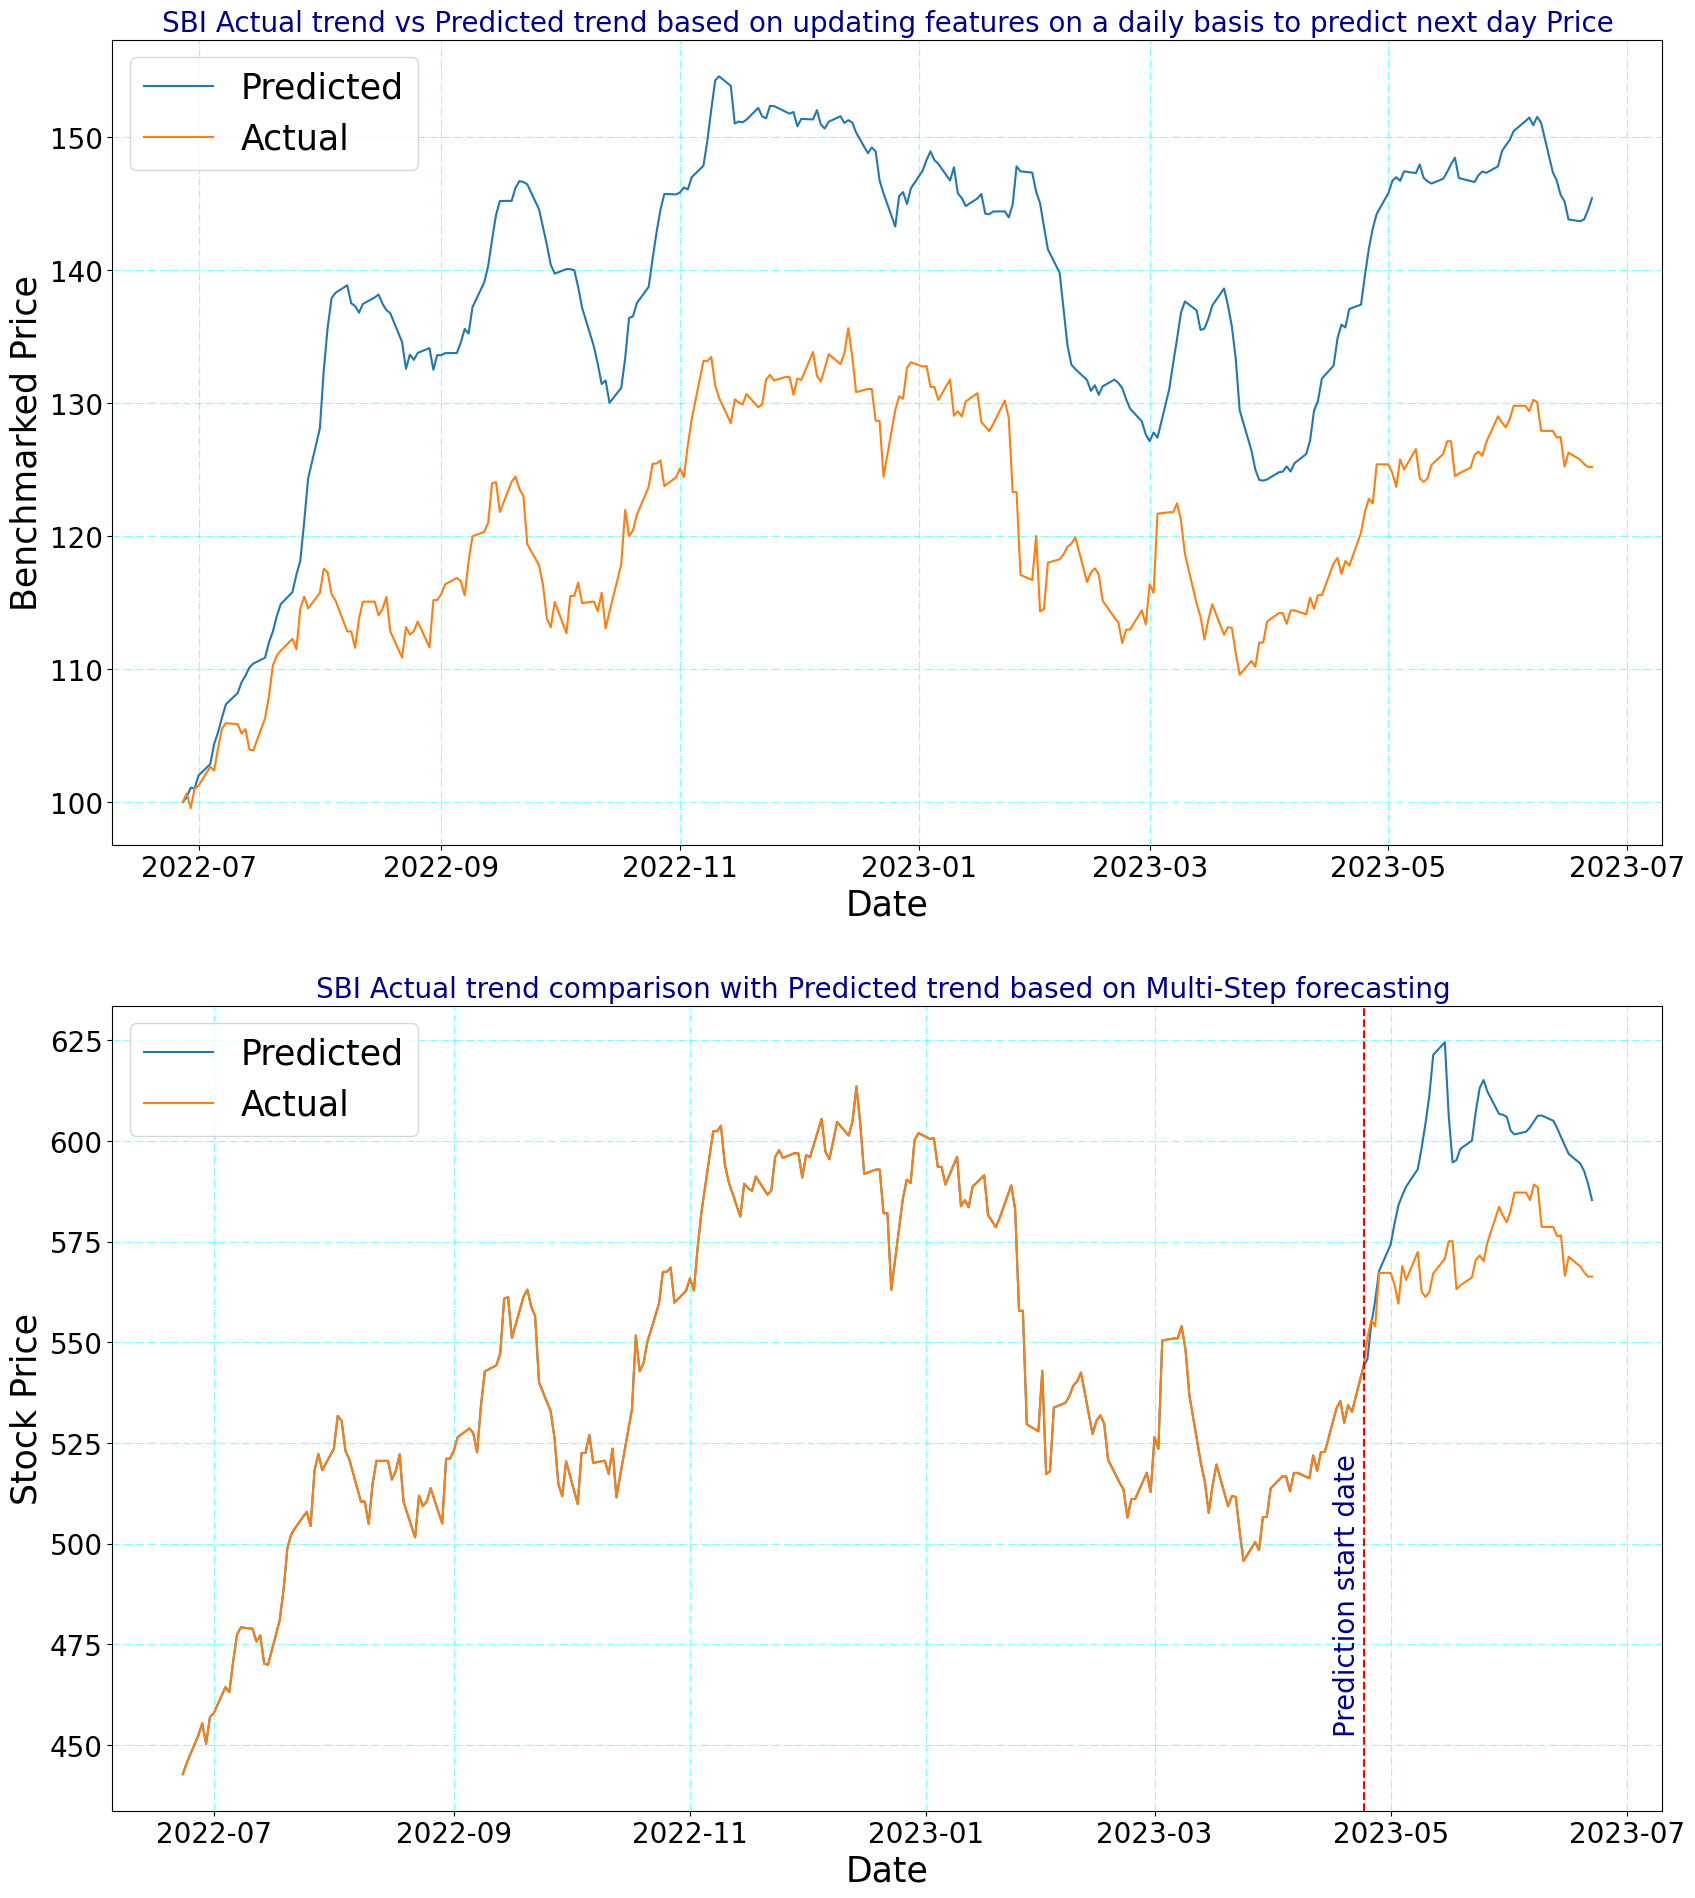

In [8]:
plotting_trend(stock, df_forecast_one_day, df_multi_step_forecasting, prediction_start_date)